/tmp/ipython-input-530334098.py:2: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"/content/drive/MyDrive/Portmap.csv")


Empty DataFrame
Columns: [Unnamed: 0, Flow ID,  Source IP,  Source Port,  Destination IP,  Destination Port,  Protocol,  Timestamp,  Flow Duration,  Total Fwd Packets,  Total Backward Packets, Total Length of Fwd Packets,  Total Length of Bwd Packets,  Fwd Packet Length Max,  Fwd Packet Length Min,  Fwd Packet Length Mean,  Fwd Packet Length Std, Bwd Packet Length Max,  Bwd Packet Length Min,  Bwd Packet Length Mean,  Bwd Packet Length Std, Flow Bytes/s,  Flow Packets/s,  Flow IAT Mean,  Flow IAT Std,  Flow IAT Max,  Flow IAT Min, Fwd IAT Total,  Fwd IAT Mean,  Fwd IAT Std,  Fwd IAT Max,  Fwd IAT Min, Bwd IAT Total,  Bwd IAT Mean,  Bwd IAT Std,  Bwd IAT Max,  Bwd IAT Min, Fwd PSH Flags,  Bwd PSH Flags,  Fwd URG Flags,  Bwd URG Flags,  Fwd Header Length,  Bwd Header Length, Fwd Packets/s,  Bwd Packets/s,  Min Packet Length,  Max Packet Length,  Packet Length Mean,  Packet Length Std,  Packet Length Variance, FIN Flag Count,  SYN Flag Count,  RST Flag Count,  PSH Flag Count,  ACK Flag Co

Done importing...
Done Loading...
Done Dropping unnecessary cols...
Label mapping: {'BENIGN': np.int64(0), 'DDoS': np.int64(1)}
Done encoding labels(multi)...
Done encoding labels(bin)...
Done replacing inf...
Done shuffling and split...

=== Multiclass Classification Report ===
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19552
        DDoS       1.00      1.00      1.00     25597

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149



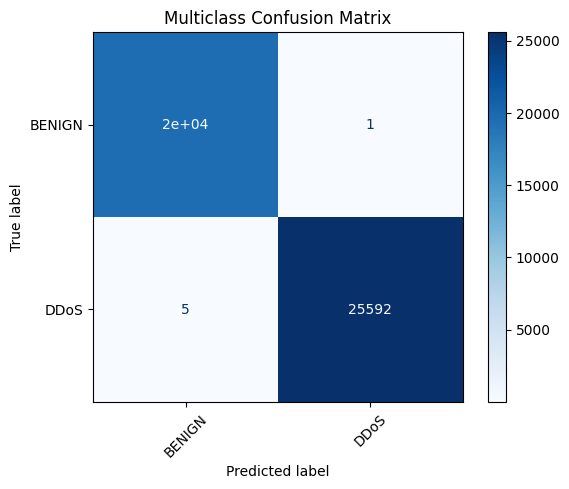


=== Binary Classification Report ===
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     19552
      Attack       1.00      1.00      1.00     25597

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149



'\n# Optional: Confusion Matrix\ncm_bin = confusion_matrix(y_test_bin, y_pred_bin)\ndisp_bin = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["Benign", "Attack"])\ndisp_bin.plot(cmap=\'Blues\')\nplt.title("Binary Confusion Matrix")\nplt.show()\n'

In [8]:
# -*- coding: utf-8 -*-
"""CICDDoS2019 KNN Dual Classification"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("Done importing...")
# ----------------------------
# Load Dataset
# ----------------------------
df = pd.read_csv(r"/content/drive/MyDrive/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df.columns = df.columns.str.strip()

print("Done Loading...")
# Drop unnecessary columns
drop_cols = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'SimillarHTTP']
df = df.drop(columns=drop_cols, errors="ignore")

print("Done Dropping unnecessary cols...")
# Encode multiclass labels
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

print("Done encoding labels(multi)...")
# Create binary label: 0 = BENIGN, 1 = Attack
df["BinaryLabel"] = df["Label"].apply(lambda x: 0 if x == 0 else 1)

print("Done encoding labels(bin)...")
# Replace inf and NaN
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
print("Done replacing inf...")
# ----------------------------
# Shuffle and split dataset
# ----------------------------
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_end = int(0.6 * len(df_shuffled))
valid_end = int(0.8 * len(df_shuffled))

train_df = df_shuffled.iloc[:train_end].copy()
valid_df = df_shuffled.iloc[train_end:valid_end].copy()
test_df  = df_shuffled.iloc[valid_end:].copy()
print("Done shuffling and split...")
# ----------------------------
# Function to scale and optionally oversample
# ----------------------------
def scale_dataset(df, target_col, oversample=False):
    X = df.drop(columns=[target_col, "BinaryLabel"])  # keep only features
    y = df[target_col].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler(random_state=42)
        X_scaled, y = ros.fit_resample(X_scaled, y)

    return X_scaled, y

# ----------------------------
# Prepare datasets for multiclass and binary
# ----------------------------
# Multiclass
X_train_multi, y_train_multi = scale_dataset(train_df, target_col="Label", oversample=True)
X_valid_multi, y_valid_multi = scale_dataset(valid_df, target_col="Label", oversample=False)
X_test_multi, y_test_multi   = scale_dataset(test_df, target_col="Label", oversample=False)

# Binary
X_train_bin, y_train_bin = scale_dataset(train_df, target_col="BinaryLabel", oversample=True)
X_valid_bin, y_valid_bin = scale_dataset(valid_df, target_col="BinaryLabel", oversample=False)
X_test_bin, y_test_bin   = scale_dataset(test_df, target_col="BinaryLabel", oversample=False)

# ----------------------------
# Train KNN - Multiclass
# ----------------------------
knn_multi = KNeighborsClassifier(n_neighbors=3)
knn_multi.fit(X_train_multi, y_train_multi)
y_pred_multi = knn_multi.predict(X_test_multi)

print("\n=== Multiclass Classification Report ===")
print(classification_report(y_test_multi, y_pred_multi, target_names=le.classes_, zero_division=0))

# Optional: Confusion Matrix
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
disp_multi = ConfusionMatrixDisplay(confusion_matrix=cm_multi, display_labels=le.classes_)
disp_multi.plot(xticks_rotation=45, cmap='Blues')
plt.title("Multiclass Confusion Matrix")
plt.show()

# ----------------------------
# Train KNN - Binary
# ----------------------------
knn_bin = KNeighborsClassifier(n_neighbors=3)
knn_bin.fit(X_train_bin, y_train_bin)
y_pred_bin = knn_bin.predict(X_test_bin)

print("\n=== Binary Classification Report ===")
print(classification_report(y_test_bin, y_pred_bin, target_names=["Benign", "Attack"], zero_division=0))
"""
# Optional: Confusion Matrix
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
disp_bin = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["Benign", "Attack"])
disp_bin.plot(cmap='Blues')
plt.title("Binary Confusion Matrix")
plt.show()
"""

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Train RF on multiclass labels
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train_multi, y_train_multi)

# Multiclass predictions
y_pred_multi = rf.predict(X_test_multi)

# Binary predictions
y_pred_binary = np.where(y_pred_multi == 0, 0, 1)

# Reports
from sklearn.metrics import classification_report

print("=== Multiclass Report ===")
print(classification_report(y_test_multi, y_pred_multi, target_names=le.classes_, zero_division=0))

print("=== Binary Report ===")
print(classification_report(y_test_bin, y_pred_binary, target_names=["Benign", "Attack"], zero_division=0))

=== Multiclass Report ===
              precision    recall  f1-score   support

      BENIGN       0.90      1.00      0.95     19552
        DDoS       1.00      0.92      0.96     25597

    accuracy                           0.95     45149
   macro avg       0.95      0.96      0.95     45149
weighted avg       0.96      0.95      0.95     45149

=== Binary Report ===
              precision    recall  f1-score   support

      Benign       0.90      1.00      0.95     19552
      Attack       1.00      0.92      0.96     25597

    accuracy                           0.95     45149
   macro avg       0.95      0.96      0.95     45149
weighted avg       0.96      0.95      0.95     45149

